# Baymax - Explainability Analysis

### 📋 Notebook Overview

This notebook implements comprehensive explainability analysis. It uses **LIME (Local Interpretable Model-agnostic Explanations)** to interpret the best-performing **Support Vector Machine (SVM)** model trained on the Baymax feature set.

### 📋 Notebook Structure

This notebook is organized into 4 main parts:
- **Part 1:** Imports & Configuration
- **Part 2:** Data Loading & Model Loading
- **Part 3:** LIME Explainer Setup & Explanation Generation
- **Part 4:** Visualization & Analysis Summary

## Part 1: Imports & Configuration

This section sets up the foundation for the explainability analysis.

### What This Cell Does:

1. **Import Libraries**
   - Standard Library: `os`, `warnings`, `pathlib`
   - Data Science: `numpy`, `pandas`
   - Visualization: `matplotlib`, `seaborn`
   - Machine Learning: `joblib` for model loading
   - Explainability: `LIME` for model interpretation

2. **Global Configuration**
   - Set random state for reproducibility (`RANDOM_STATE = 42`)
   - Configure pandas display options
   - Set plotting styles and figure parameters
   - Define figure format and DPI settings

3. **Path Configuration**
   - Define base directory
   - Set input paths:
     - Baymax feature set directory (`features/`)
     - Trained SVM model path (`models/svm.pkl`)
   - Set output directories:
     - Results (HTML explanations, CSV weights)
     - Figures (visualization plots)
     - Summary (comprehensive reports)

4. **Target & Class Configuration**
   - Define target column name: `"Mental Health Status Encoded"`
   - Define class names: `["Stable", "Challenged", "Critical"]`
   - Set number of classes: `3`
   - Set number of top features to explain: `10`

In [1]:
# ============================================================================
# STANDARD LIBRARY IMPORTS
# ============================================================================
import os
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")

# ============================================================================
# DATA SCIENCE & NUMERICAL COMPUTING
# ============================================================================
import numpy as np
import pandas as pd

# ============================================================================
# VISUALIZATION
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# ============================================================================
# MACHINE LEARNING - MODEL PERSISTENCE
# ============================================================================
import joblib

# ============================================================================
# EXPLAINABILITY
# ============================================================================
from lime.lime_tabular import LimeTabularExplainer

# ============================================================================
# GLOBAL CONFIGURATION
# ============================================================================
# Random State for Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Pandas Display Options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Plotting Configuration
sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 120})

# Figure Settings
FIG_FORMAT = "png"
FIG_DPI = 300

# ============================================================================
# PATH CONFIGURATION
# ============================================================================
# Base Directory
BASE_DIR = Path.cwd().parents[0]

# Input Paths - Baymax Feature Set
FEATURES_DIR = BASE_DIR / "features"
MODEL_PATH = BASE_DIR / "models" / "svm.pkl"

# Output Paths
RESULTS_DIR = BASE_DIR / "results" / "Explainability Analysis"
FIGURES_DIR = BASE_DIR / "figures" / "Explainability Analysis"
SUMMARY_DIR = BASE_DIR / "summary"

# ============================================================================
# TARGET & CLASS CONFIGURATION
# ============================================================================
# Target Column Name
TARGET_COL = "Mental Health Status Encoded"

# Class Names
CLASS_NAMES = ["Stable", "Challenged", "Critical"]
NUM_CLASSES = len(CLASS_NAMES)

# Number of top features to explain
NUM_FEATURES = 10

# ============================================================================
# DIRECTORY CREATION
# ============================================================================
for directory in [RESULTS_DIR, FIGURES_DIR, SUMMARY_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("IMPORTS, CONFIGURATION & PATH SETUP COMPLETE")

IMPORTS, CONFIGURATION & PATH SETUP COMPLETE


## Part 2: Data Loading & Model Loading

This section loads all necessary data and the trained SVM model for explainability analysis.

### What This Cell Does:

1. **Load Test Data**
   - Loads `test.csv` from the Baymax features directory
   - Verifies the file exists and displays shape
   - Shows all column names for verification

2. **Separate Features and Target**
   - Extracts feature matrix (`X_test`) by dropping the target column
   - Extracts target labels (`y_test`) and converts to integer type
   - Displays shapes and feature names
   - Shows number of features being analyzed (10 features)

3. **Display Class Distribution**
   - Counts samples per class in the test set
   - Shows distribution: Stable, Challenged, Critical
   - Displays both counts and percentages
   - Validates balanced/imbalanced dataset

4. **Load SVM Model**
   - Loads the pre-trained SVM classifier (`svm.pkl`)
   - Verifies model file exists at the specified path
   - Displays model type and confirms successful loading
   - Note: SVM was trained with `probability=True`, enabling `predict_proba` for LIME compatibility

5. **Load Training Data for LIME Explainer**
   - Loads `train.csv` from the Baymax features directory
   - Separates training features (`X_train`) and labels (`y_train`)
   - LIME requires training data to understand feature distributions
   - Verifies feature names match between train and test sets

In [2]:
# ============================================================================
# LOAD TEST DATA
# ============================================================================
print("\n" + "=" * 80)
print("PART 2: DATA LOADING & MODEL LOADING")
print("=" * 80)

TEST_DATA_PATH = FEATURES_DIR / "test.csv"
print(f"\n📊 Loading test data from: {TEST_DATA_PATH}")

if not TEST_DATA_PATH.exists():
    raise FileNotFoundError(f"Test data not found at: {TEST_DATA_PATH}")

test_df = pd.read_csv(TEST_DATA_PATH)
print(f"  Test data shape: {test_df.shape}")
print(f"  Columns: {list(test_df.columns)}")

# Verify target column exists
if TARGET_COL not in test_df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in test data")

# ============================================================================
# SEPARATE FEATURES AND TARGET
# ============================================================================
print(f"\n📊 Separating features and target...")

X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL].astype(int)

print(f"  Features shape: {X_test.shape}")
print(f"  Target shape:   {y_test.shape}")

# Get feature names
feature_names = X_test.columns.tolist()
print(f"  Number of features: {len(feature_names)}")
print(f"  Feature names: {feature_names}")

# ============================================================================
# DISPLAY CLASS DISTRIBUTION
# ============================================================================
print(f"\n📊 Test set class distribution:")
class_counts = y_test.value_counts().sort_index()
for class_id, count in class_counts.items():
    percentage = (count / len(y_test)) * 100
    class_name = CLASS_NAMES[class_id]
    print(f"  Class {class_id} ({class_name:12s}): {count:3d} samples ({percentage:5.2f}%)")

# ============================================================================
# LOAD SVM MODEL
# ============================================================================
print(f"\n📊 Loading SVM model from: {MODEL_PATH}")

if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found at: {MODEL_PATH}")

model = joblib.load(MODEL_PATH)
print(f"  Model type: {type(model).__name__}")
print(f"  Model loaded successfully")

# ============================================================================
# LOAD TRAINING DATA FOR LIME EXPLAINER
# ============================================================================
print(f"\n📊 Loading training data for LIME explainer...")

TRAIN_DATA_PATH = FEATURES_DIR / "train.csv"

if not TRAIN_DATA_PATH.exists():
    raise FileNotFoundError(f"Training data not found at: {TRAIN_DATA_PATH}")

train_df = pd.read_csv(TRAIN_DATA_PATH)
X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL].astype(int)

print(f"  Training data shape: {X_train.shape}")
print(f"  Training samples:    {len(X_train)}")
print(f"  Features match test set: {list(X_train.columns) == feature_names}")


PART 2: DATA LOADING & MODEL LOADING

📊 Loading test data from: d:\Programming\Projects\Baymax\features\test.csv
  Test data shape: (405, 27)
  Columns: ['PSS1', 'PSS2', 'PSS3', 'PSS4', 'PSS5', 'PSS6', 'PSS7', 'PSS8', 'PSS9', 'PSS10', 'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'PHQ1', 'PHQ2', 'PHQ3', 'PHQ4', 'PHQ5', 'PHQ6', 'PHQ7', 'PHQ8', 'PHQ9', 'Mental Health Status Encoded']

📊 Separating features and target...
  Features shape: (405, 26)
  Target shape:   (405,)
  Number of features: 26
  Feature names: ['PSS1', 'PSS2', 'PSS3', 'PSS4', 'PSS5', 'PSS6', 'PSS7', 'PSS8', 'PSS9', 'PSS10', 'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'PHQ1', 'PHQ2', 'PHQ3', 'PHQ4', 'PHQ5', 'PHQ6', 'PHQ7', 'PHQ8', 'PHQ9']

📊 Test set class distribution:
  Class 0 (Stable      ):  25 samples ( 6.17%)
  Class 1 (Challenged  ): 223 samples (55.06%)
  Class 2 (Critical    ): 157 samples (38.77%)

📊 Loading SVM model from: d:\Programming\Projects\Baymax\models\svm.pkl
  Model type: SV

## Part 3: LIME Explainer Setup & Explanation Generation

This section initializes the LIME explainer and generates explanations for representative samples from each mental health status class.

### What This Cell Does:

1. **Initialize LIME Explainer**
   - Creates a `LimeTabularExplainer` object using training data
   - Configures explainer with feature names and class names
   - Sets discretization for continuous features
   - Uses classification mode for 3-class problem
   - Sets random state for reproducibility

2. **Select Representative Samples**
   - Selects one representative sample from each class:
     - **Stable** (Class 0)
     - **Challenged** (Class 1)
     - **Critical** (Class 2)
   - Finds the first test sample from each class
   - Stores sample index, features, true label, and class name
   - Ensures all classes are represented in the analysis

3. **Generate LIME Explanations**

   For each selected sample:
   - **Generate Explanation:** Uses LIME to explain the model's prediction via `predict_proba` (enabled by `probability=True` on the SVM)
   - **Get Predictions:** Retrieves predicted class and probabilities
   - **Save HTML:** Exports interactive LIME explanation as HTML file
   - **Extract Weights:** Captures feature contribution weights
   - **Save CSV:** Stores feature weights with metadata
   - **Display Top 5:** Shows the 5 most important features

4. **Feature Weight Analysis**

   Each CSV file contains:
   - Feature description
   - Contribution weight (positive/negative)
   - Absolute weight magnitude
   - Class ID and class name
   - Sample index
   - True label vs predicted label
   - Predicted class name

In [3]:
# ============================================================================
# INITIALIZE LIME EXPLAINER
# ============================================================================
print("\n" + "=" * 80)
print("PART 3: LIME EXPLAINER SETUP & EXPLANATION GENERATION")
print("=" * 80)

print(f"\n📊 Setting up LIME Tabular Explainer...")

explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=CLASS_NAMES,
    discretize_continuous=True,
    mode="classification",
    random_state=RANDOM_STATE
)

print(f"✅ LIME explainer initialized")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Features:         {len(feature_names)}")
print(f"  Classes:          {NUM_CLASSES} {CLASS_NAMES}")
print(f"  Mode:             classification")

# ============================================================================
# SELECT REPRESENTATIVE SAMPLES FROM EACH CLASS
# ============================================================================
print(f"\n📊 Selecting representative samples from each class...")

selected_samples = {}
for class_id in range(NUM_CLASSES):
    class_indices = y_test[y_test == class_id].index.tolist()

    if len(class_indices) == 0:
        print(f"  📊 No samples found for class {class_id} ({CLASS_NAMES[class_id]})")
        continue

    sample_idx = class_indices[0]
    selected_samples[class_id] = {
        "index": sample_idx,
        "features": X_test.loc[sample_idx].values,
        "true_label": class_id,
        "class_name": CLASS_NAMES[class_id]
    }

    print(f"  ✅ Class {class_id} ({CLASS_NAMES[class_id]:12s}): Sample index {sample_idx}")

print(f"\n📊 Total samples selected: {len(selected_samples)}/{NUM_CLASSES}")

# ============================================================================
# GENERATE LIME EXPLANATIONS FOR EACH CLASS
# ============================================================================
print(f"\n📊 Generating LIME explanations for each class...")
print(f"  Top features to explain: {NUM_FEATURES}")

summary_rows = []

for class_id, sample_info in selected_samples.items():
    class_name = sample_info["class_name"]
    instance = sample_info["features"]

    print(f"\n  {'─' * 76}")
    print(f"  📊 Class: {class_name} (ID: {class_id})")
    print(f"  {'─' * 76}")
    print(f"  Sample index: {sample_info['index']}")
    print(f"  Generating explanation...")

    try:
        # Generate LIME explanation
        exp = explainer.explain_instance(
            instance,
            model.predict_proba,
            num_features=NUM_FEATURES,
            top_labels=NUM_CLASSES
        )

        # Get predicted probabilities
        pred_probs = model.predict_proba([instance])[0]
        pred_class = np.argmax(pred_probs)
        pred_class_name = CLASS_NAMES[pred_class]

        print(f"  True label:  {class_name} (ID: {class_id})")
        print(f"  Predicted:   {pred_class_name} (ID: {pred_class})")
        print(f"  Prediction probabilities:")
        for i, prob in enumerate(pred_probs):
            print(f"    {CLASS_NAMES[i]:12s}: {prob:.4f}")

        # Save HTML explanation
        html_filename = f"lime_{class_name.lower().replace(' ', '_')}_class_{class_id}.html"
        html_path = RESULTS_DIR / html_filename
        exp.save_to_file(str(html_path))
        print(f"  ✅ HTML explanation saved: {html_filename}")

        # Extract feature weights for this class
        lime_list = exp.as_list(label=class_id)
        weights_df = pd.DataFrame(lime_list, columns=["Feature", "Weight"])
        weights_df["Absolute_Weight"] = abs(weights_df["Weight"])
        weights_df = weights_df.sort_values("Absolute_Weight", ascending=False)

        # Add metadata
        weights_df["Class_ID"] = class_id
        weights_df["Class_Name"] = class_name
        weights_df["Sample_Index"] = sample_info["index"]
        weights_df["True_Label"] = sample_info["true_label"]
        weights_df["Predicted_Label"] = pred_class
        weights_df["Predicted_Class"] = pred_class_name

        # Save feature weights to CSV
        csv_filename = f"lime_{class_name.lower().replace(' ', '_')}_class_{class_id}_weights.csv"
        csv_path = RESULTS_DIR / csv_filename
        weights_df.to_csv(csv_path, index=False)
        print(f"  ✅ Feature weights saved: {csv_filename}")

        # Display top 5 features
        print(f"  📊 Top 5 features by absolute weight:")
        for idx, row in weights_df.head(5).iterrows():
            sign = "+" if row["Weight"] > 0 else ""
            print(f"    {row['Feature']:40s}: {sign}{row['Weight']:.4f}")

        summary_rows.append(weights_df)
        print(f"  ✅ LIME explanation completed for class: {class_name}")

    except Exception as e:
        print(f"  ❌ Error generating LIME for class {class_name}: {e}")
        continue


PART 3: LIME EXPLAINER SETUP & EXPLANATION GENERATION

📊 Setting up LIME Tabular Explainer...
✅ LIME explainer initialized
  Training samples: 1617
  Features:         26
  Classes:          3 ['Stable', 'Challenged', 'Critical']
  Mode:             classification

📊 Selecting representative samples from each class...
  ✅ Class 0 (Stable      ): Sample index 8
  ✅ Class 1 (Challenged  ): Sample index 0
  ✅ Class 2 (Critical    ): Sample index 1

📊 Total samples selected: 3/3

📊 Generating LIME explanations for each class...
  Top features to explain: 10

  ────────────────────────────────────────────────────────────────────────────
  📊 Class: Stable (ID: 0)
  ────────────────────────────────────────────────────────────────────────────
  Sample index: 8
  Generating explanation...
  True label:  Stable (ID: 0)
  Predicted:   Stable (ID: 0)
  Prediction probabilities:
    Stable      : 0.8917
    Challenged  : 0.1054
    Critical    : 0.0029
  ✅ HTML explanation saved: lime_stable_class

## Part 4: Visualization & Analysis Summary

This section creates comprehensive visualizations and generates detailed analysis summaries of the LIME explanations.

### What This Cell Does:

1. **Helper Function**
   - `save_fig()`
     - Defines function to save figures to the figures directory
     - Creates directory if it doesn't exist
     - Saves in PNG format with specified DPI

2. **Create Visualizations for Each Class**

   For each class (Stable, Challenged, Critical):
   - **Load Feature Weights:** Reads saved CSV file
   - **Sort by Weight:** Orders features from most negative to most positive
   - **Color Code:** Green for positive contributions, red for negative
   - **Create Bar Chart:** Horizontal bars showing feature contributions
   - **Add Labels:** Value labels on each bar
   - **Add Zero Line:** Dashed vertical line at zero
   - **Add Legend:** Explains color coding
   - **Save Figure:** Exports high-resolution PNG

3. **Create Comprehensive Summary**
   - Combines all weight data into a single DataFrame
   - Saves comprehensive summary CSV
   - Shows total records and location
   - Validates data aggregation

4. **Prediction Accuracy on Selected Samples**
   - Checks if predictions match true labels
   - Calculates accuracy percentage
   - Shows per-class prediction results
   - Validates model performance on explained samples


PART 4: VISUALIZATION & ANALYSIS SUMMARY

📊 Creating visualizations for each class...

  ────────────────────────────────────────────────────────────────────────────
  📊 Creating visualization for: Stable (Class 0)
  ────────────────────────────────────────────────────────────────────────────


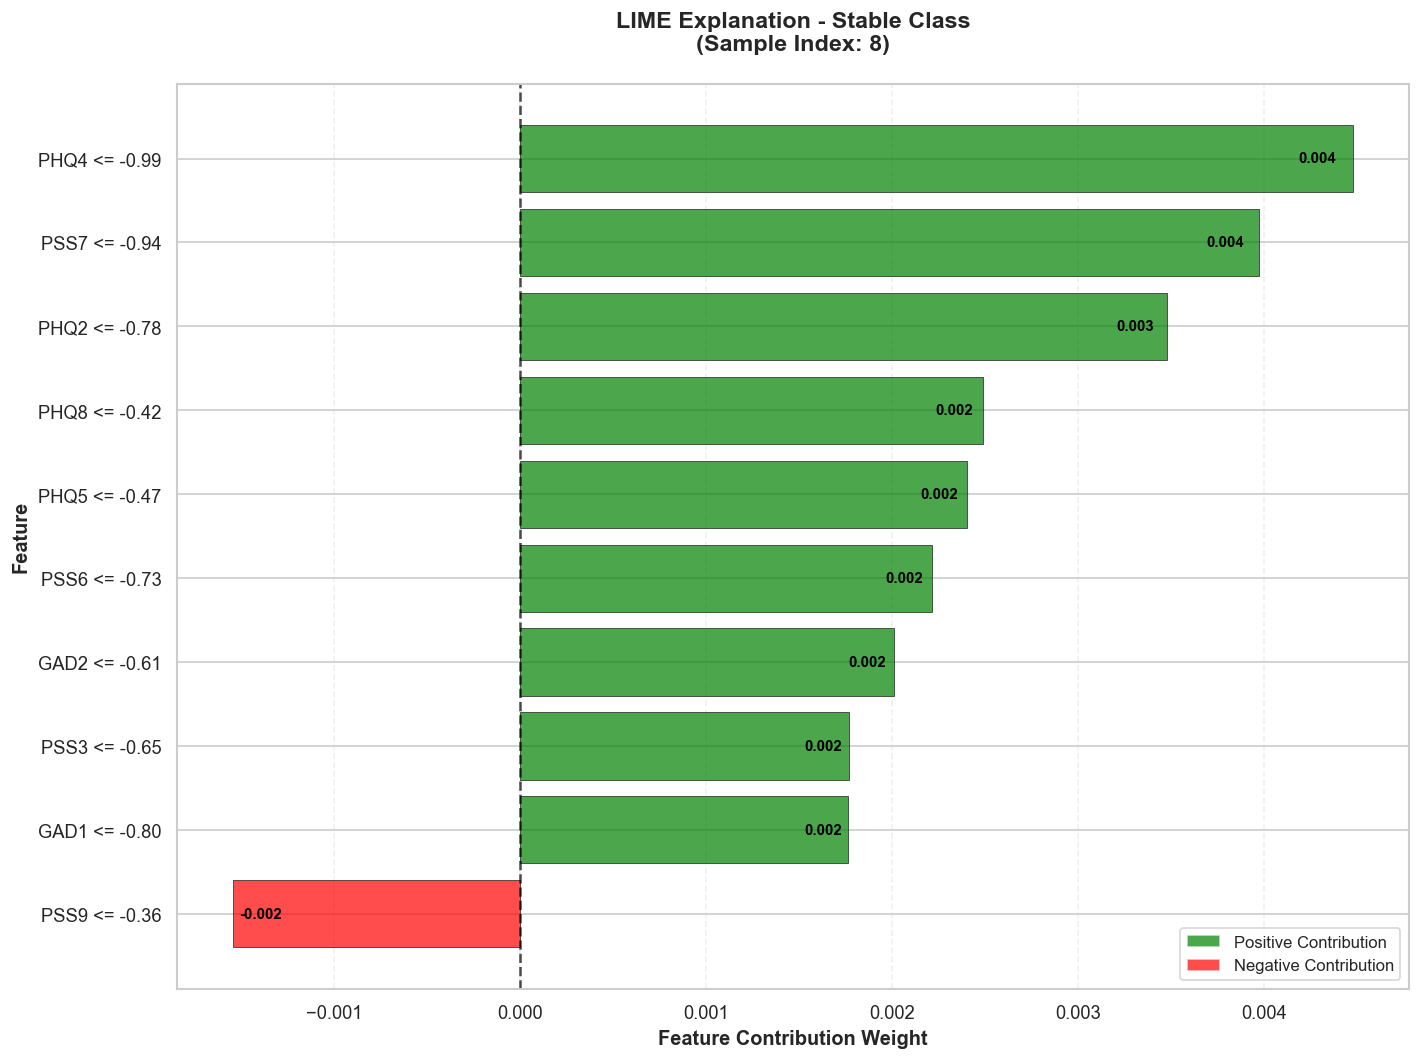

  ✅ Figure saved: lime_stable_class_0.png
  ✅ Visualization created and saved
  📊 Features displayed:      10
  📊 Positive contributions:  9
  📊 Negative contributions:  1

  ────────────────────────────────────────────────────────────────────────────
  📊 Creating visualization for: Challenged (Class 1)
  ────────────────────────────────────────────────────────────────────────────


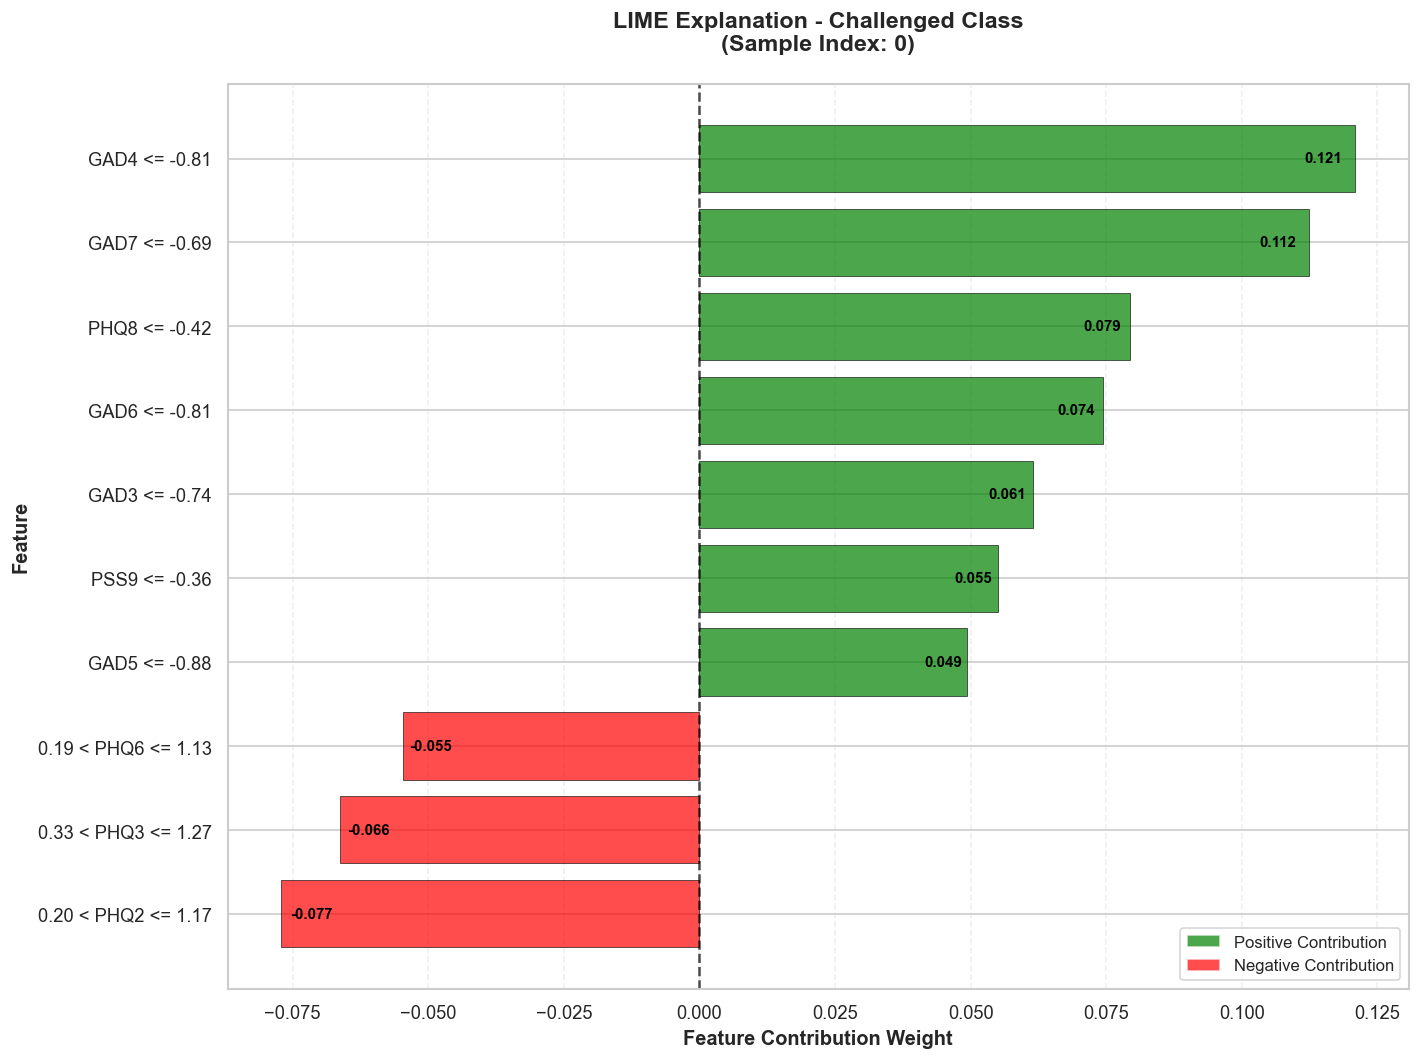

  ✅ Figure saved: lime_challenged_class_1.png
  ✅ Visualization created and saved
  📊 Features displayed:      10
  📊 Positive contributions:  7
  📊 Negative contributions:  3

  ────────────────────────────────────────────────────────────────────────────
  📊 Creating visualization for: Critical (Class 2)
  ────────────────────────────────────────────────────────────────────────────


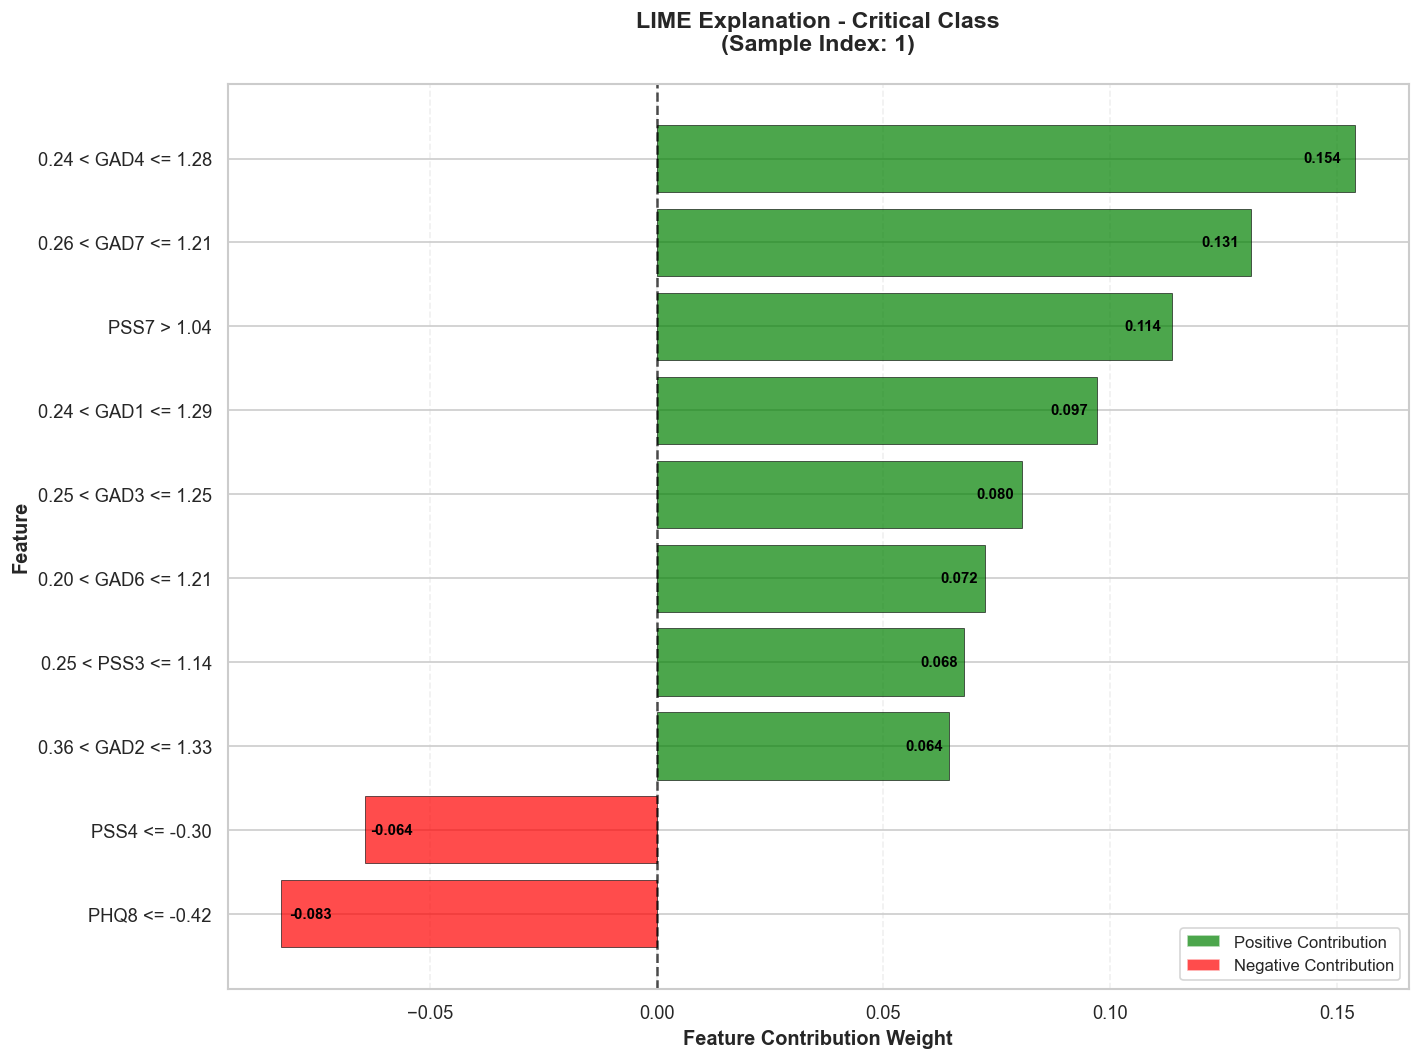

  ✅ Figure saved: lime_critical_class_2.png
  ✅ Visualization created and saved
  📊 Features displayed:      10
  📊 Positive contributions:  8
  📊 Negative contributions:  2

ANALYSIS SUMMARY & FINAL RESULTS

📊 Creating comprehensive summary...
✅ Comprehensive summary saved: lime_summary.csv
  Location:      d:\Programming\Projects\Baymax\summary\lime_summary.csv
  Total records: 30

📊 PREDICTION ACCURACY ON SELECTED SAMPLES

  Overall Accuracy: 100.00% (3/3)

  Per-Class Predictions:
  ✅ Stable       (True: 0, Predicted: 0 - Stable)
  ✅ Challenged   (True: 1, Predicted: 1 - Challenged)
  ✅ Critical     (True: 2, Predicted: 2 - Critical)


In [4]:
# ============================================================================
# HELPER FUNCTION - SAVE FIGURE
# ============================================================================
print("\n" + "=" * 80)
print("PART 4: VISUALIZATION & ANALYSIS SUMMARY")
print("=" * 80)

def save_fig(fig, name, fig_dir):
    """Save figure to the specified figures directory"""
    fig_dir.mkdir(parents=True, exist_ok=True)
    path = fig_dir / f"{name}.{FIG_FORMAT}"
    fig.savefig(path, format=FIG_FORMAT, bbox_inches="tight", dpi=FIG_DPI)
    print(f"  ✅ Figure saved: {name}.{FIG_FORMAT}")
    plt.close(fig)

# ============================================================================
# CREATE VISUALIZATIONS FOR EACH CLASS
# ============================================================================
print(f"\n📊 Creating visualizations for each class...")

visualization_count = 0

for class_id, sample_info in selected_samples.items():
    class_name = sample_info["class_name"]

    print(f"\n  {'─' * 76}")
    print(f"  📊 Creating visualization for: {class_name} (Class {class_id})")
    print(f"  {'─' * 76}")

    # Load the saved weights
    csv_filename = f"lime_{class_name.lower().replace(' ', '_')}_class_{class_id}_weights.csv"
    csv_path = RESULTS_DIR / csv_filename

    if not csv_path.exists():
        print(f"  📊 No weights file found for {class_name}, skipping visualization")
        continue

    weights_df = pd.read_csv(csv_path)

    # Sort by weight for better visualization (most negative to most positive)
    weights_sorted = weights_df.sort_values("Weight")

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 9))

    # Color code: green for positive contributions, red for negative
    colors = ["green" if val > 0 else "red" for val in weights_sorted["Weight"]]

    # Create horizontal bar chart
    bars = ax.barh(
        weights_sorted["Feature"],
        weights_sorted["Weight"],
        color=colors,
        edgecolor="black",
        linewidth=0.5,
        alpha=0.7
    )

    # Add vertical line at zero
    ax.axvline(0, color="black", linewidth=1.5, alpha=0.7, linestyle="--")

    # Get axis range for dynamic spacing
    x_min, x_max = ax.get_xlim()

    for bar, weight in zip(bars, weights_sorted["Weight"]):
        y_pos = bar.get_y() + bar.get_height() / 2
        bar_width = bar.get_width()
        padding = abs(bar_width) * 0.02
        ax.text(
            bar_width - padding if bar_width > 0 else bar_width + padding,
            y_pos,
            f'{weight:.3f}',
            ha='right' if bar_width > 0 else 'left',
            va='center',
            fontsize=9,
            fontweight='bold',
            color='black'
        )

    # Customize plot
    ax.set_xlabel("Feature Contribution Weight", fontsize=12, fontweight='bold')
    ax.set_ylabel("Feature", fontsize=12, fontweight='bold')
    ax.set_title(
        f"LIME Explanation - {class_name} Class\n(Sample Index: {sample_info['index']})",
        fontsize=14,
        fontweight='bold',
        pad=20
    )

    # Add grid for better readability
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Add legend
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='Positive Contribution'),
        Patch(facecolor='red', alpha=0.7, label='Negative Contribution')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Save figure
    fig_filename = f"lime_{class_name.lower().replace(' ', '_')}_class_{class_id}"
    save_fig(fig, fig_filename, FIGURES_DIR)

    visualization_count += 1

    print(f"  ✅ Visualization created and saved")
    print(f"  📊 Features displayed:      {len(weights_sorted)}")
    print(f"  📊 Positive contributions:  {sum(weights_sorted['Weight'] > 0)}")
    print(f"  📊 Negative contributions:  {sum(weights_sorted['Weight'] < 0)}")

# ============================================================================
# CREATE COMPREHENSIVE SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("ANALYSIS SUMMARY & FINAL RESULTS")
print("=" * 80)

print(f"\n📊 Creating comprehensive summary...")

if summary_rows:
    # Combine all summary data
    lime_summary = pd.concat(summary_rows, ignore_index=True)

    # Save comprehensive summary
    summary_path = SUMMARY_DIR / "lime_summary.csv"
    lime_summary.to_csv(summary_path, index=False)
    print(f"✅ Comprehensive summary saved: {summary_path.name}")
    print(f"  Location:      {summary_path}")
    print(f"  Total records: {len(lime_summary)}")

    # ============================================================================
    # PREDICTION ACCURACY ON SELECTED SAMPLES
    # ============================================================================
    print(f"\n{'=' * 80}")
    print("📊 PREDICTION ACCURACY ON SELECTED SAMPLES")
    print("=" * 80)

    # Get unique samples (one per class)
    sample_predictions = lime_summary.drop_duplicates(subset=["Class_ID"])
    correct_predictions = sample_predictions[
        sample_predictions["True_Label"] == sample_predictions["Predicted_Label"]
    ]

    accuracy = len(correct_predictions) / len(sample_predictions) if len(sample_predictions) > 0 else 0

    print(f"\n  Overall Accuracy: {accuracy:.2%} ({len(correct_predictions)}/{len(sample_predictions)})")
    print(f"\n  Per-Class Predictions:")
    for _, row in sample_predictions.iterrows():
        correct = "✅" if row["True_Label"] == row["Predicted_Label"] else "❌"
        print(f"  {correct} {row['Class_Name']:12s} (True: {row['True_Label']}, Predicted: {row['Predicted_Label']} - {row['Predicted_Class']})")

else:
    print(f"\n📊 No summary data available")